# Histogram sampling

In [1]:
import os
import sys

from matplotlib import pyplot as plt
import numpy as np
import proplot as pplt

sys.path.append("..")
import psdist as ps
import psdist.visualization as psv

pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

Create distribution.

In [2]:
d = 6
n = int(1e4)
dims = ["x", "px", "y", "py", "z", "pz"]

state = np.random.RandomState(1241)
_Sigma = np.identity(d)
for i in range(d):
    for j in range(i):
        _Sigma[i, j] = _Sigma[j, i] = state.uniform(-0.2, 0.2)
X = state.multivariate_normal(np.zeros(d), _Sigma, size=n)
for _ in range(4):
    scale = state.uniform(0.5, 1.5, size=d)
    loc = state.uniform(-3.0, 3.0, size=d)
    X = np.vstack([X, state.normal(loc=loc, scale=scale, size=(n, d))])
X = X - np.mean(X, axis=0)

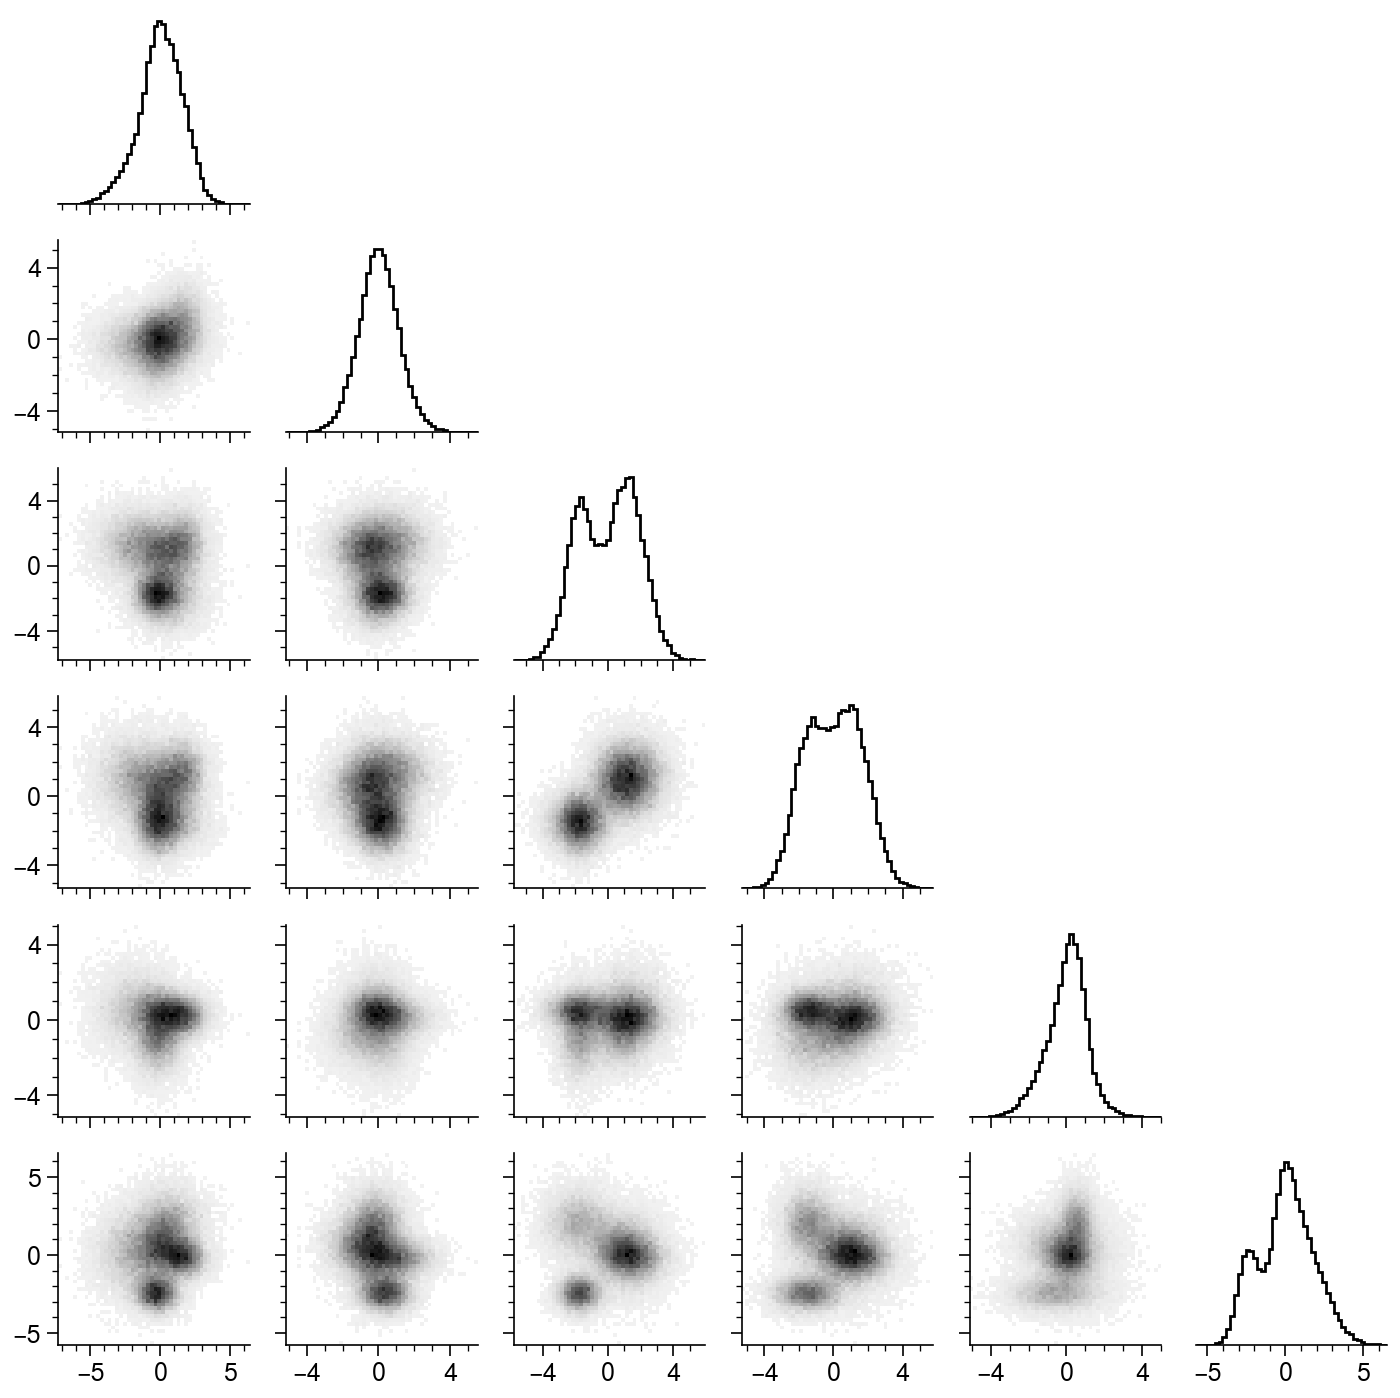

In [3]:
limits = psv.cloud.auto_limits(X)
psv.cloud.corner(
    X, 
    bins=50, 
    limits=limits, 
    grid_kws=dict(figwidth=7.0), 
    cmap=pplt.Colormap("mono", left=0.05), 
)
plt.show()

Compute histogram.

In [4]:
n_bins = 30
hist, coords = ps.cloud.histogram(X, bins=n_bins, limits=limits, centers=True)
print("hist.size =", hist.size)

hist.size = 729000000


Sample from histogram.

In [5]:
n_samples = int(1e5)
X_sample = ps.image.sample_hist(hist, coords=coords, samples=int(n_samples))

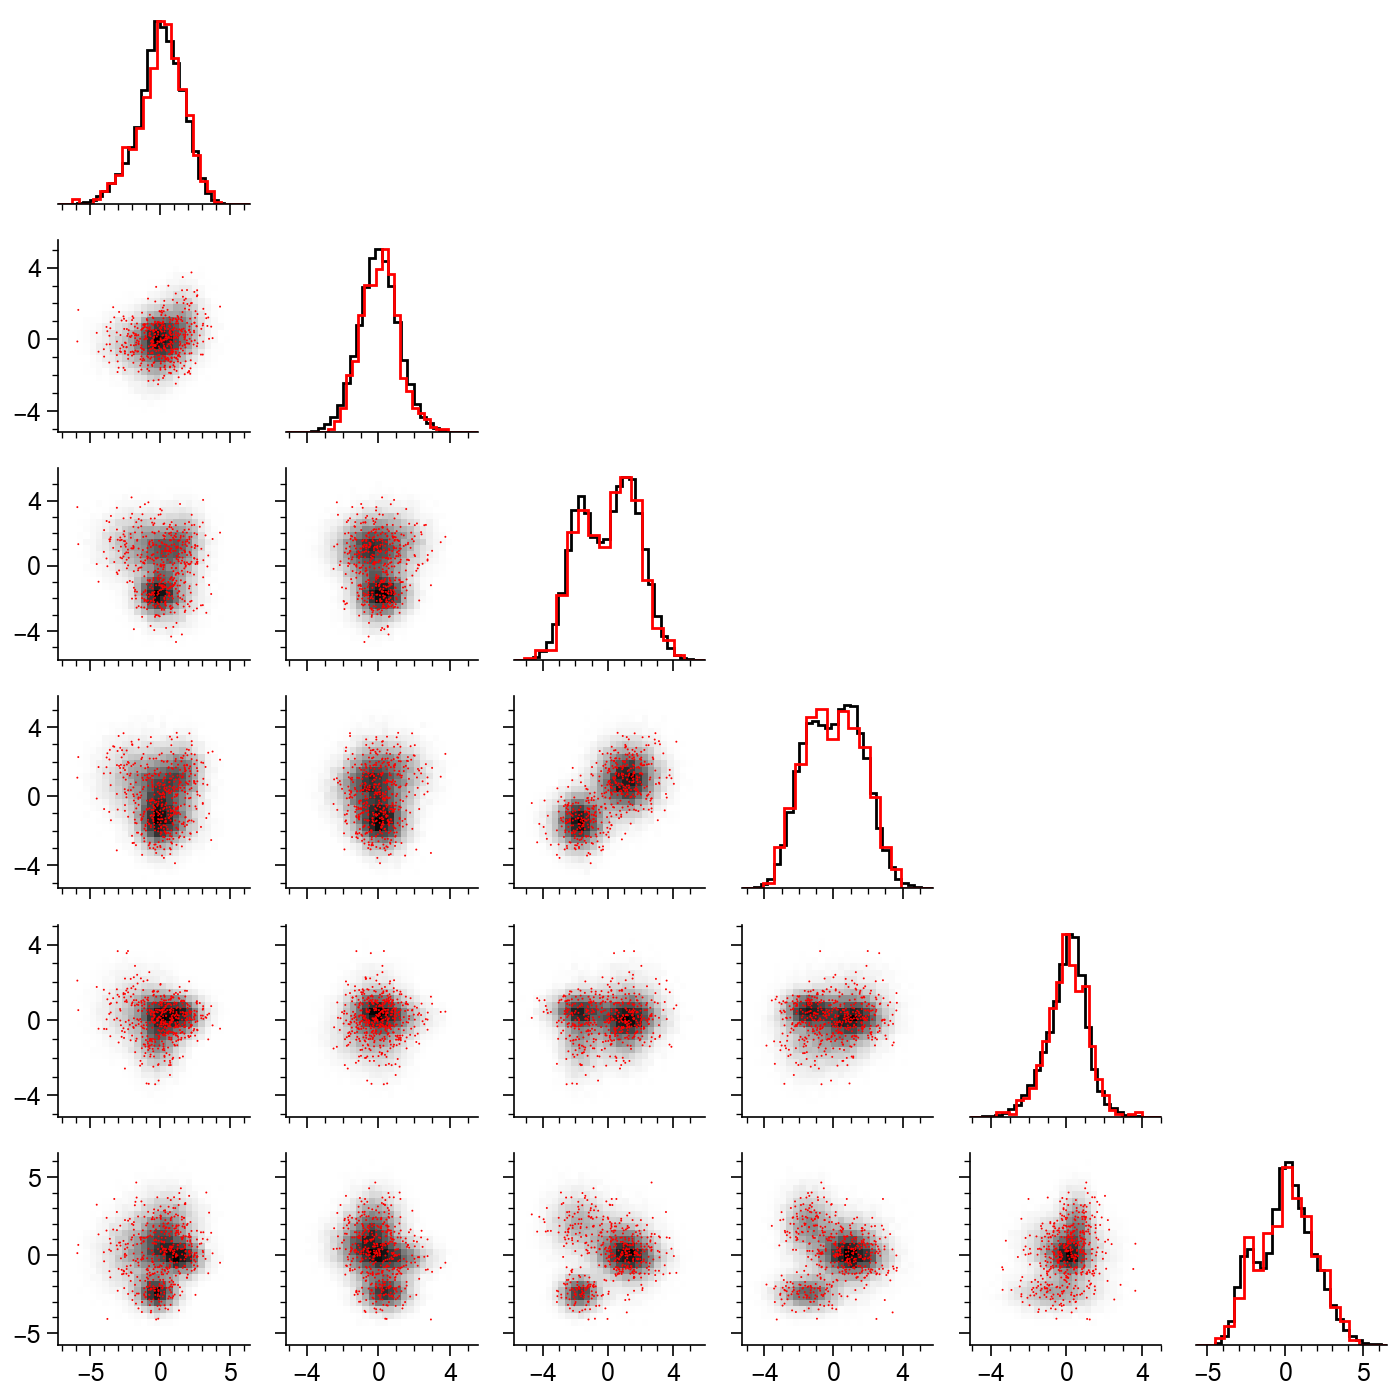

In [6]:
grid = psv.CornerGrid(d=6, figwidth=7.0)
grid.plot_image(hist, coords=coords, cmap=pplt.Colormap("mono"))
grid.plot_cloud(
    X_sample[:500, :], 
    kind="scatter", 
    color="red", 
    s=0.5, 
    diag_kws=dict(color="red")
)

Compute sparse histogram.

In [7]:
nonzero_indices, nonzero_counts, nonzero_coords = ps.cloud.sparse_histogram(X, bins=n_bins, limits=limits, centers=True)
print("sparse_hist.size =", len(nonzero_counts))

sparse_hist.size = 49283


Sample from sparse histogram.

In [8]:
X_sample_sparse = ps.image.sample_sparse_hist(
    indices=nonzero_indices, 
    counts=nonzero_counts, 
    coords=nonzero_coords, 
    samples=n_samples,
)

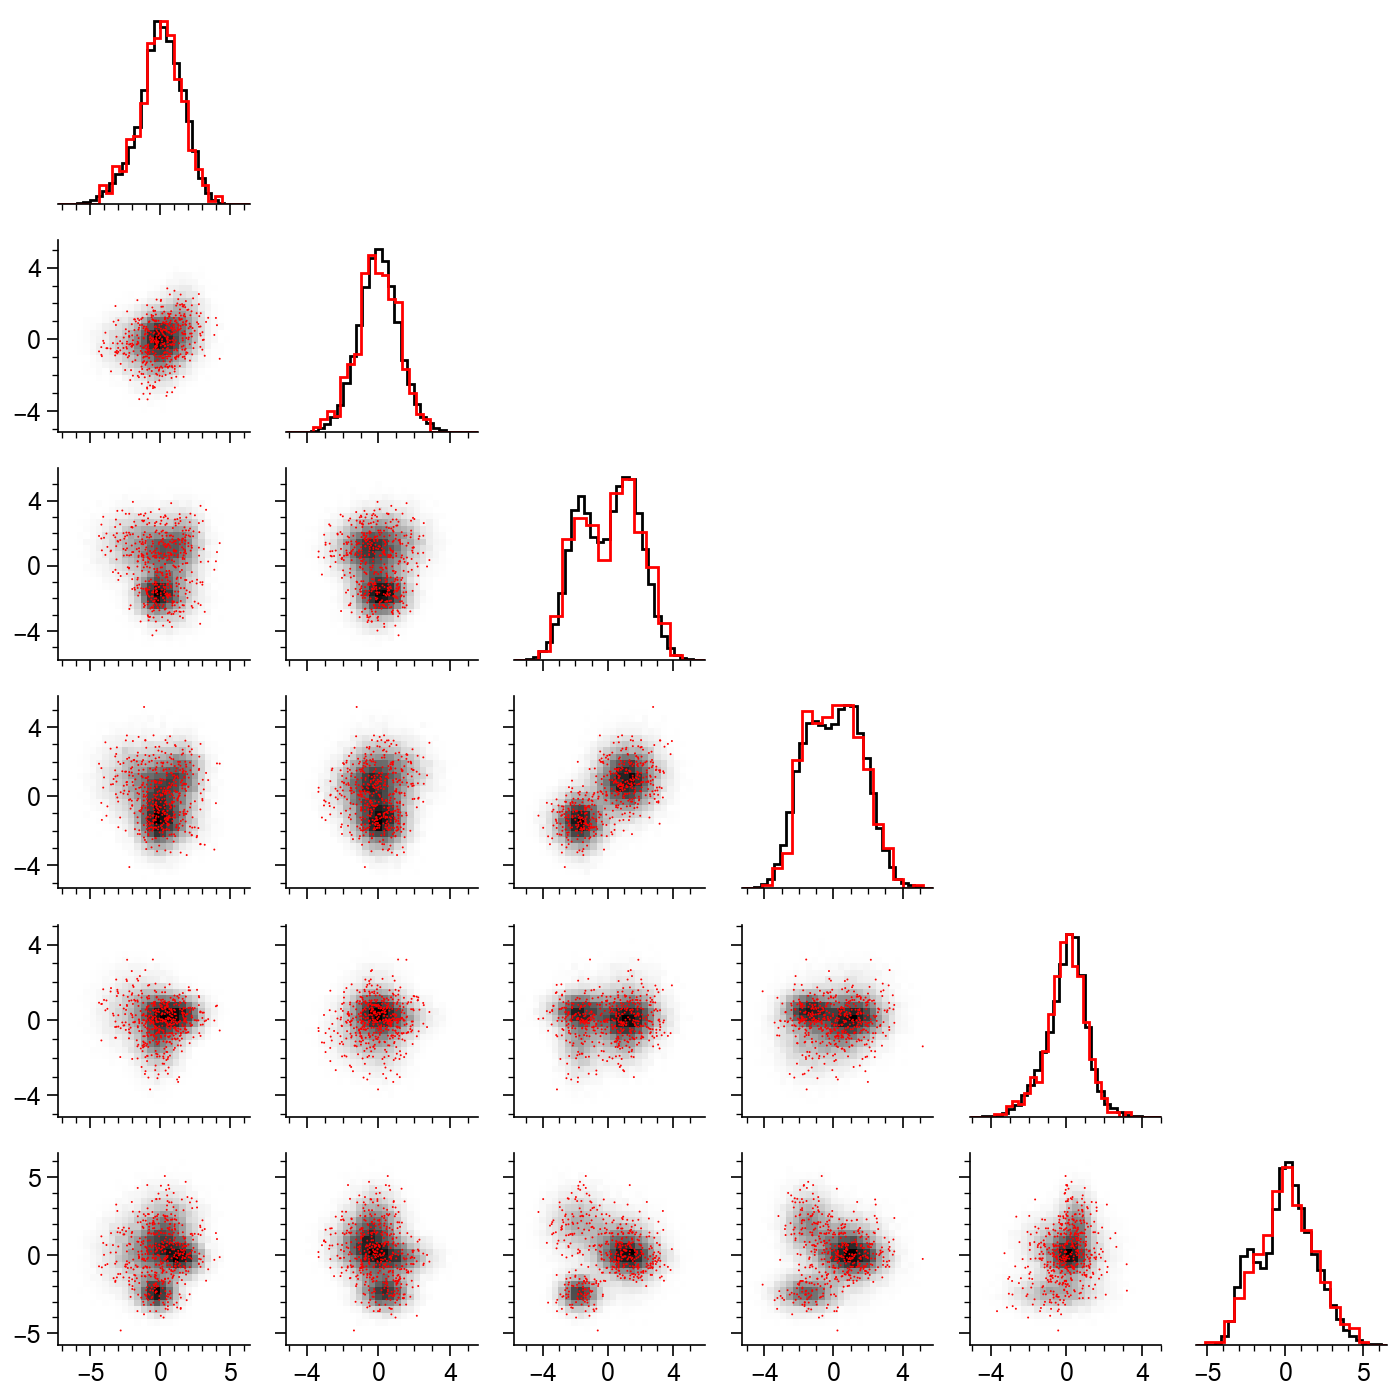

In [9]:
grid = psv.CornerGrid(d=6, figwidth=7.0)
grid.plot_image(hist, coords=coords, cmap=pplt.Colormap("mono"))
grid.plot_cloud(
    X_sample_sparse[:500, :], 
    kind="scatter", 
    color="red", 
    s=0.5, 
    diag_kws=dict(color="red")
)

Compare sparse and regular histogram samples.

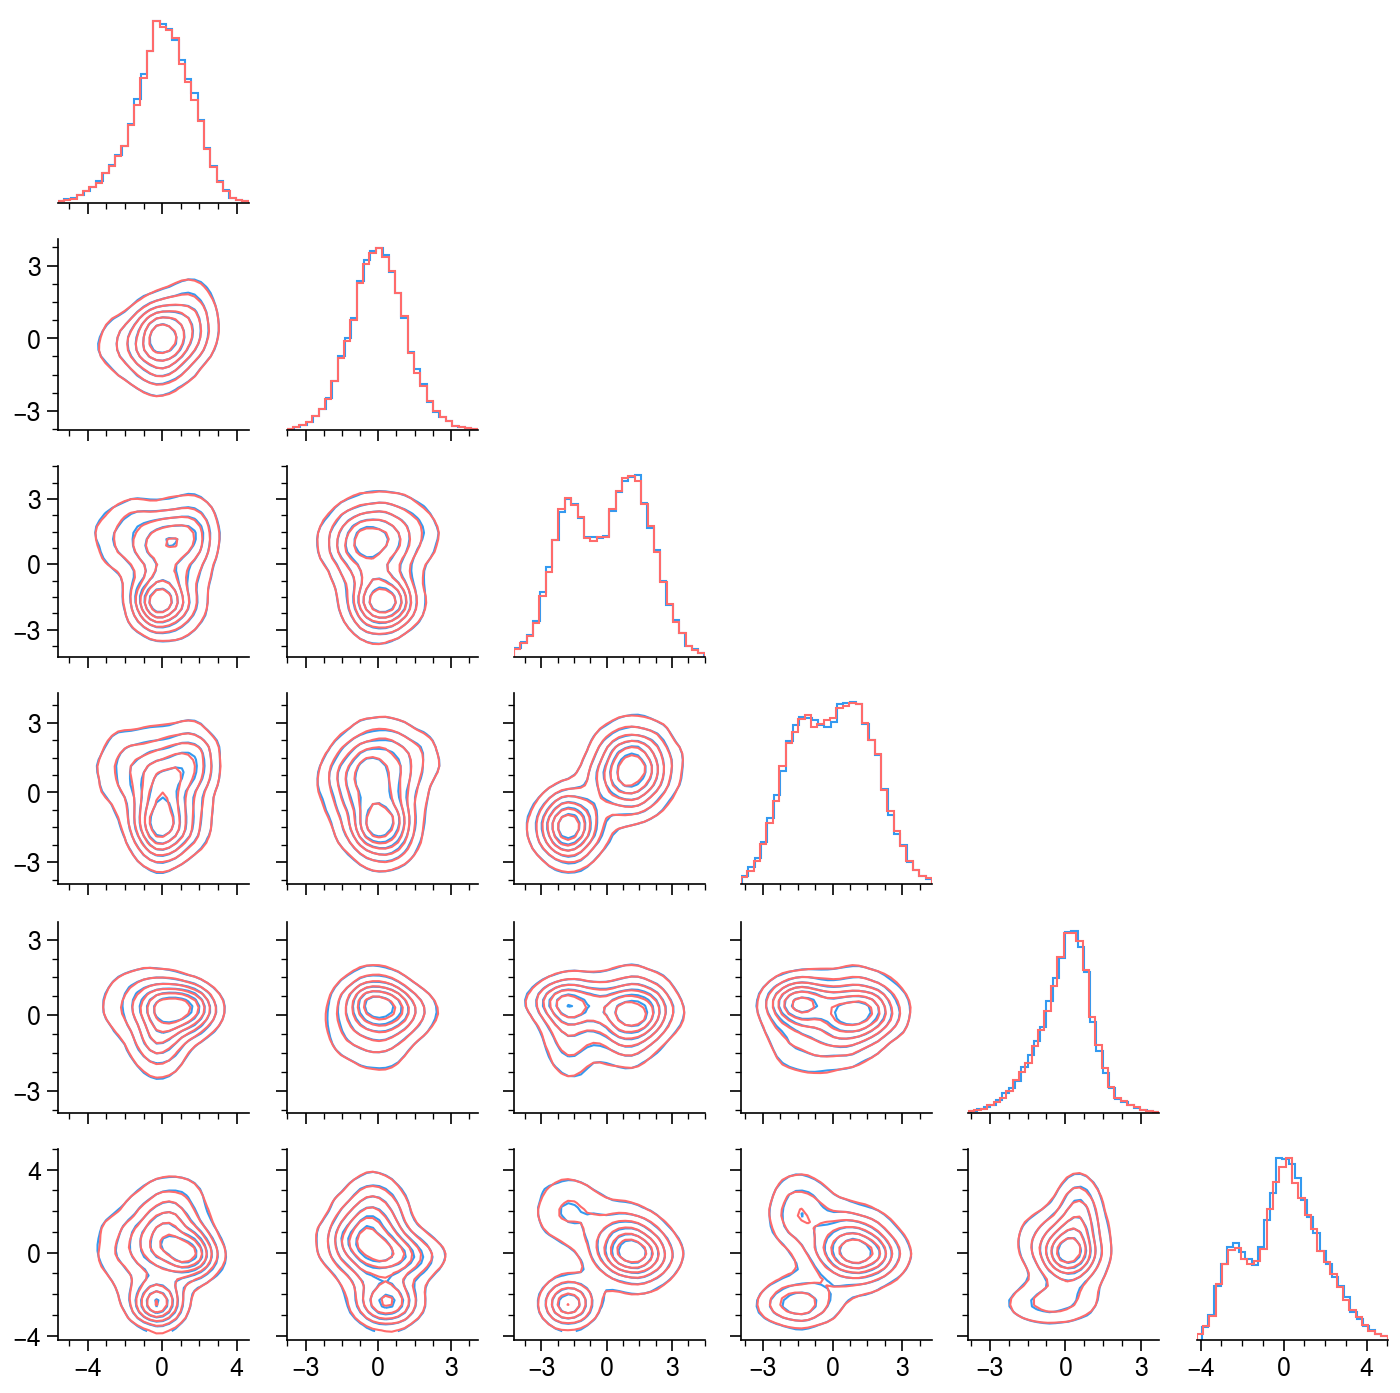

In [10]:
grid = psv.CornerGrid(d=6, figwidth=7.0)
for color, _X in zip(["blue5", "red5"], [X_sample, X_sample_sparse]):
    grid.plot_cloud(
        _X[:, :], 
        bins=30, 
        autolim_kws=dict(pad=-0.25),
        kind="contour", 
        process_kws=dict(norm="max", blur_sigma=1.0), 
        diag_kws=dict(color=color, lw=0.75),
        levels=np.linspace(0.0, 1.0, 7, endpoint=False)[1:],
        colors=color, 
        lw=0.75,
    )